# Importing libraries

In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Help functions

## Load data

In [3]:
def load_battery_voltage(pack_nr):
#     print("Loading the battery voltage and resampling to 5min intervals...")
    df = pd.read_csv(r'C:\Users\JeffG\Desktop\Case 1 - data\battery_data_' + str(pack_nr) +'\Power.BatteryVoltHR_merged.csv',usecols=['time','value'])
    # Select timestamp and value from results
    data = df[['time','value']]
    # Convert object to float (BatteryVoltHR is an object for example)
    data["value"] = pd.to_numeric(data.value, errors='coerce')
    # Rename the column
    data.rename(columns={'value':'Power.BatteryVoltHR'}, inplace=True)
    # Set timestamp as index
    data['time'] = pd.to_datetime(data.time, unit='ms')
    data = data.resample(rule='5Min', on='time').mean().interpolate()
    return data

In [4]:
def load_weather_data():
    weather_metricsList = ['environment.light','environment.temperature','weather.uv','environment.relativehumidity',
              'weather.pressure', 'weather.rainrate', 'weather.windspeed']
    for i in range(0,len(weather_metricsList)):     
        metricID = weather_metricsList[i]
#         print("Loading " + str(metricID) + " and resampling to 5min intervals...")
        df = pd.read_csv('C:/Users/JeffG/Desktop/Case 1 - data/weather_data/'+metricID+'_merged.csv',usecols=['time','value'])

        if(i==0):
            # Select timestamp and value from results
            data = df[['time','value']]
            # Convert object to float (BatteryVoltHR is an object for example)
            data["value"] = pd.to_numeric(data.value, errors='coerce')
            # Rename the column
            data.rename(columns={'value': metricID}, inplace=True)
            # Calculate average for time bin and replace NaN with interpolation
            data['time'] = pd.to_datetime(data.time, unit='ms')
            data = data.resample(rule='5Min', on='time').mean().interpolate()
        else:
            data2 = df[['time','value']]
            # Convert object to float (BatteryVoltHR is an object for example)
            data2["value"] = pd.to_numeric(data2.value, errors='coerce')
            # Rename the column
            data2.rename(columns={'value':metricID}, inplace=True)
            # Calculate average for time bin and replace NaN with interpolation
            data2['time'] = pd.to_datetime(data2.time, unit='ms')
            data2 = data2.resample(rule='5Min', on='time').mean().interpolate()
            data = pd.merge(data, data2, on='time')
        
    return data

In [5]:
def get_data(pack_nr):
    battery_data = load_battery_voltage(pack_nr)
    weather_data = load_weather_data()
    data = pd.merge(battery_data, weather_data, on='time')
    return data

## Extend data features

In [6]:
def add_features(X, y, nr_ts_bat, nr_ts_weather):
    if nr_ts_bat != 0:
        for i in range(1,nr_ts_bat+1):
            shifted_data = y['Power.BatteryVoltHR'].shift(periods=i)
            name = 'Power.BatteryVoltHR (t-{})'.format(i)
            X[name] = shifted_data
        X = X.dropna()
    y = y.iloc[nr_ts_weather:]
    return X, y       

In [7]:
def series_to_supervised(data, indexes, column_names, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    	data: Sequence of observations as a list or NumPy array.
    	indexes: values of timestamp indexes
    	column_names: names of the columns
    	n_in: Number of lag observations as input (X).
    	n_out: Number of observations as output (y).
    	dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    	Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(column_names[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(column_names[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(column_names[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Set timestamps back as indexes
    agg = agg.set_index(indexes)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Scale and Split dataset

In [8]:
import sklearn.preprocessing

In [9]:
def scale_data(data):
    # Save column names
    col_names = data.columns
    # load dataset
    values = data.values
    indexes = data.index
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    # Transform back to dataframe
    scaled = pd.DataFrame(scaled, columns=col_names).set_index(indexes)
    
    return scaled, scaler

In [10]:
def split_data(data, training_ratio):
    # split into train and test sets
    values = data.values
    n_train = int(training_ratio * len(data))
    train = data.iloc[0:n_train]
    test = data.iloc[n_train:-1]
    # split into input and outputs
    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0:1]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0:1]
    
    return X_train, y_train, X_test, y_test

## Rescale features

In [11]:
def combine_XY(X, y, scaler):
    ct = pd.concat([y, X], sort=False, axis = 1)
    ct = scaler.inverse_transform(ct)
    return ct

## Plot results

In [12]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [13]:
def plot_pred_actual(X_test, y_test, y_pred, prev_timesteps, batt_nr):
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(y_test.index, y_test, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.legend()
    plt.title('Linear Regression - No Regularization \n Prev timesteps: {} \n'.format(prev_timesteps))
#     plt.savefig(r'C:\Users\JeffG\Desktop\Case 1 - data\Results\Linear Regression' + '/ts_{}_batt_{}'.format(prev_timesteps, batt_nr))
    plt.show()
    return fig

In [14]:
def plot_pred_actual_2(X_test, y_test, y_pred, prev_timesteps, batt_nr, scaler):
    y_test_real = combine_XY(X_test, y_test, scaler)[:, 0]
    y_pred_real = combine_XY(X_test, pd.DataFrame(y_pred).set_index(X_test.index), scaler)[:, 0]
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(X_test.index, y_test_real, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred_real, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.legend()
    plt.title('Linear Regression - No Regularization \n Prev timesteps: {} \n'.format(prev_timesteps))
#     plt.savefig(r'C:\Users\JeffG\Desktop\Case 1 - data\Results\Linear Regression' + '/ts_{}_batt_{}'.format(prev_timesteps, batt_nr))
    plt.show()
    return fig

# Linear Regression (no regularization)

## Import library

In [15]:
from sklearn import linear_model
import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score

## Using built-in functions

In [16]:
weather_data = load_weather_data()

In [137]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings

prev_timesteps = 3

# Preprocess data
X, y = add_features(a, b, prev_timesteps)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

Training score: 0.9999046771459726
Test score: 0.9999091790666974


In [141]:
print("Coefficients: ")
coeff = pd.DataFrame(pipeline.named_steps['model'].coef_)
print(coeff)
coeff.to_csv(r'C:\Users\JeffG\Desktop\Case 1 - data\Results\Linear Regression' + "/coeff.csv")

Coefficients: 
          0         1         2         3         4         5         6  \
0  0.013295 -0.001212 -0.008977  0.001359 -0.000335 -0.001737 -0.000249   

          7         8         9  
0  1.638369  0.330284  0.061425  


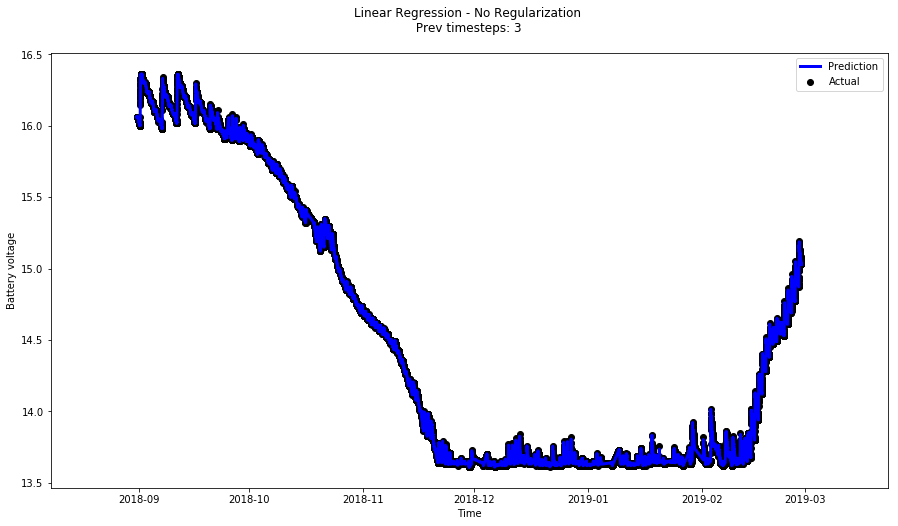

Test score: 0.9999714054710737


In [139]:
# Choose battery data
batt_nr = 3
battery_voltage = load_battery_voltage(batt_nr)
b = battery_voltage.copy()

# Preprocess data
X_test, y_test = add_features(a, b, prev_timesteps)

# Predict values based on trained set
y_pred = pipeline.predict(X_test)

# Plot the results
plot_pred_actual(X_test, y_test, y_pred, prev_timesteps, batt_nr)
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

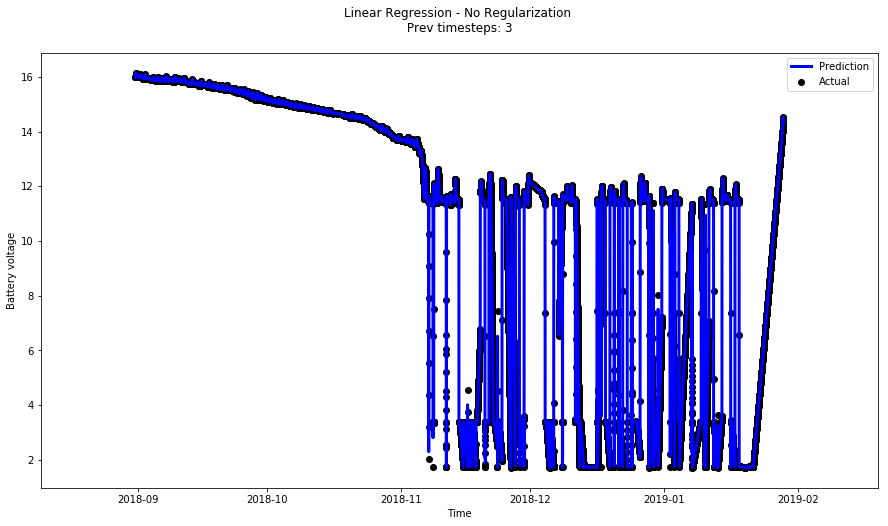

Test score: 0.9962894324839547


In [140]:
# Choose battery data
batt_nr = 1
battery_voltage = load_battery_voltage(batt_nr)
b = battery_voltage.copy()

# Preprocess data
X_test, y_test = add_features(a, b, prev_timesteps)

# Predict values based on trained set
y_pred = pipeline.predict(X_test)

# Plot the results
plot_pred_actual(X_test, y_test, y_pred, prev_timesteps, batt_nr)
print('Test score: {}'.format(pipeline.score(X_test.iloc[0:len(y_test)], y_test)))

## Using extra features

In [18]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 3
prev_timesteps_bat = 0

# Extend the weather data with more timestamps
X_ext = series_to_supervised(a, a.index, a.columns, n_in=prev_timesteps_weather, n_out=1, dropnan=True)
X, y = add_features(X_ext, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

Training score: 0.470198863560202
Test score: 0.4697138379450492


## Define experiment

In [29]:
def linear_regression_experiment(batt_nr, prev_timesteps, training_ratio, train, regr):
    # Get data
    print("Loading data...")
    data = get_data(batt_nr)
    # Extend data with features
    extended_data = add_features(data, prev_timesteps)
    # Scale data and split
    scaled_data, scaler = scale_data(extended_data)
    X_train, y_train, X_test, y_test = split_data(scaled_data, training_ratio)
    print(regr)
    if train == True:
        # Create linear regression object
        regr = linear_model.LinearRegression()
        # Train the model using the training sets
        regr.fit(X_train, y_train)
    # Make predictions using the testing set
    print(regr)
    y_pred = regr.predict(X_test)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print("Mean squared error: %.5f"
          % mse)
    # Explained variance score: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Variance score: %.5f' % r2)
    
    plot_pred_actual(X_test, y_test, y_pred, prev_timesteps, batt_nr, scaler)
    
    return regr, mse, r2

## Run experiments for battery packs

Loading data...
None
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[-0.09811476  0.40954524  0.11079549 -0.21926348 -0.90220009 -0.09542676
  -0.24730647]]
Mean squared error: 0.21225
Variance score: -0.67850


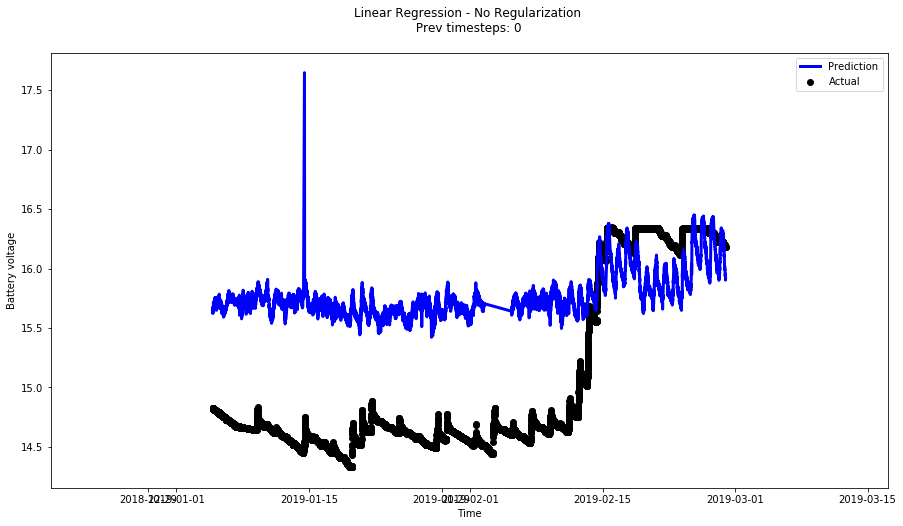

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[-0.09811476  0.40954524  0.11079549 -0.21926348 -0.90220009 -0.09542676
  -0.24730647]]
Mean squared error: 0.27318
Variance score: -1.22121


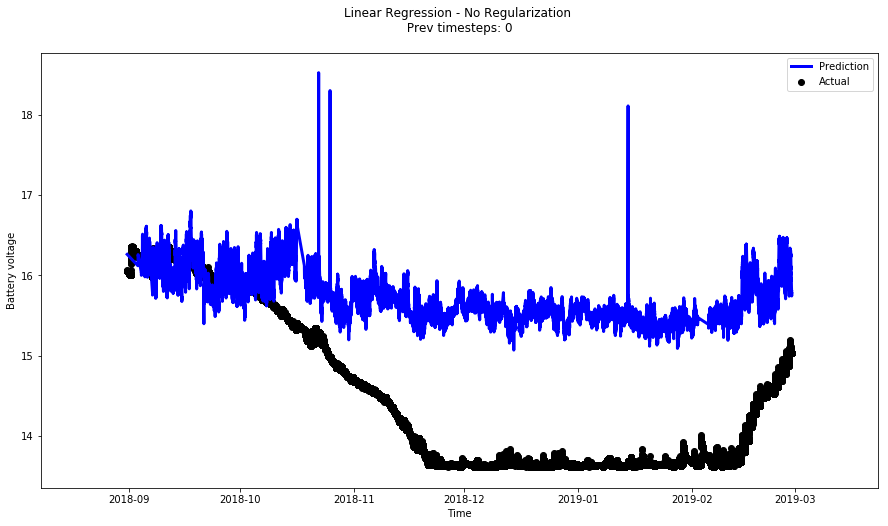

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[-0.09811476  0.40954524  0.11079549 -0.21926348 -0.90220009 -0.09542676
  -0.24730647]]
Mean squared error: 0.10731
Variance score: 0.10226


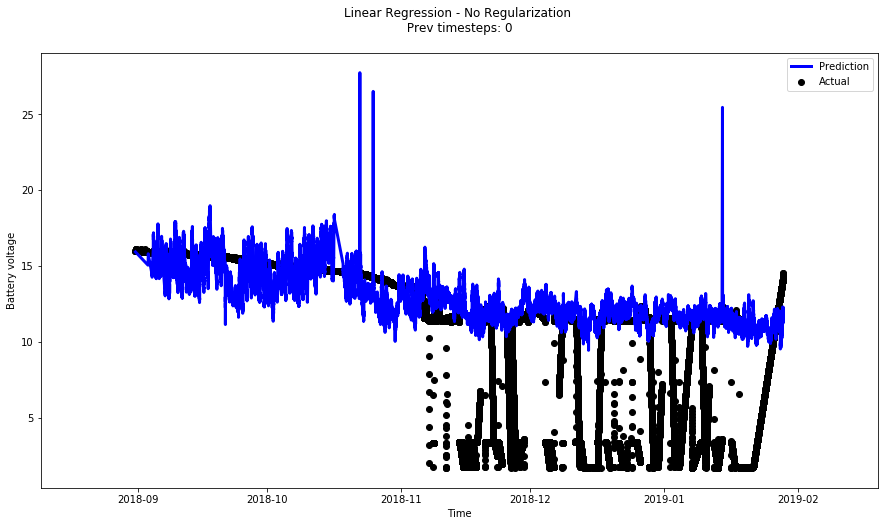

Loading data...
None
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 5.20884105e-03 -3.73671592e-04 -2.79916027e-03  5.69261479e-04
  -2.46457240e-04 -5.28057645e-04 -1.30414306e-04  9.99865230e-01]]
Mean squared error: 0.00001
Variance score: 0.99990


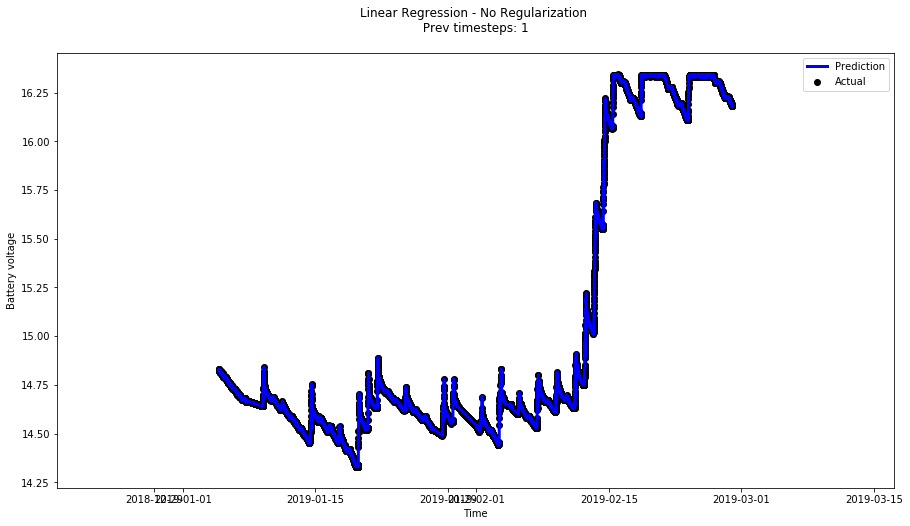

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 5.20884105e-03 -3.73671592e-04 -2.79916027e-03  5.69261479e-04
  -2.46457240e-04 -5.28057645e-04 -1.30414306e-04  9.99865230e-01]]
Mean squared error: 0.00000
Variance score: 0.99997


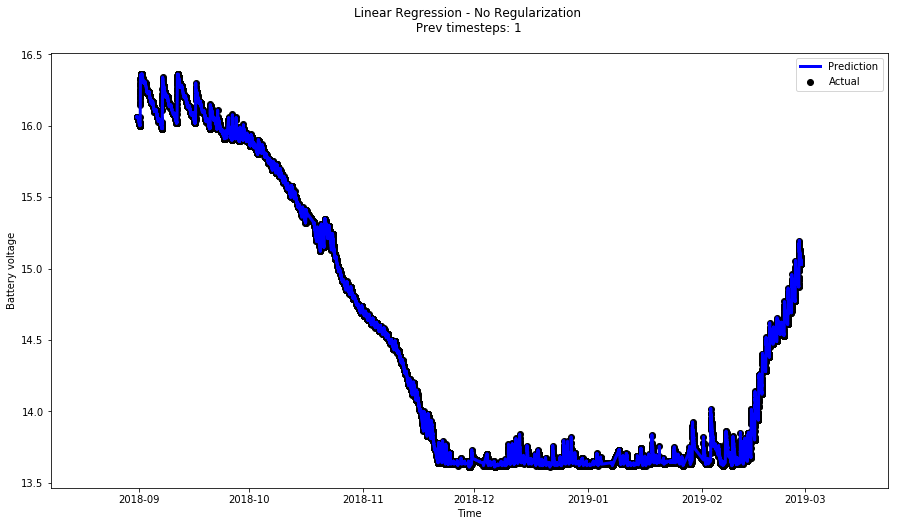

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 5.20884105e-03 -3.73671592e-04 -2.79916027e-03  5.69261479e-04
  -2.46457240e-04 -5.28057645e-04 -1.30414306e-04  9.99865230e-01]]
Mean squared error: 0.00042
Variance score: 0.99649


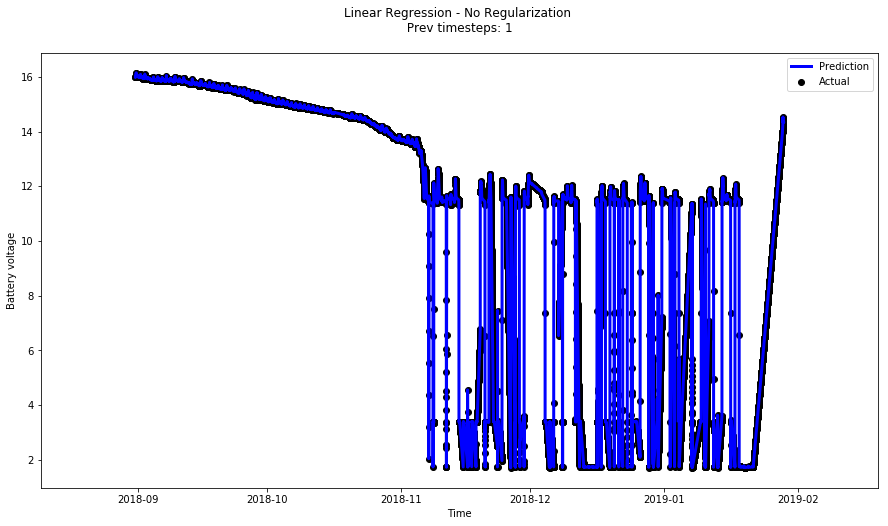

Loading data...
None
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 6.09725638e-03 -4.68708326e-04 -3.26789606e-03  6.62068339e-04
  -1.51950725e-04 -5.69123547e-04 -1.17012443e-04  8.17229795e-01
   1.69757069e-01  1.29202079e-02]]
Mean squared error: 0.00001
Variance score: 0.99990


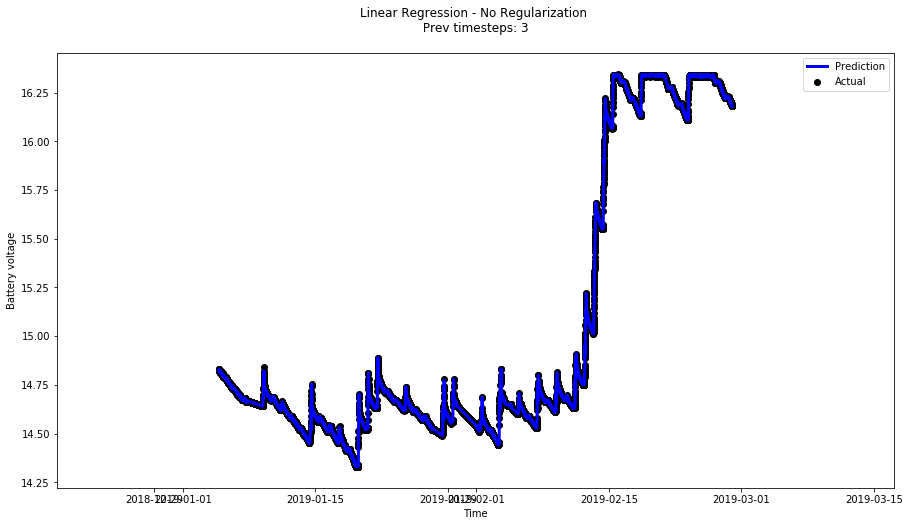

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 6.09725638e-03 -4.68708326e-04 -3.26789606e-03  6.62068339e-04
  -1.51950725e-04 -5.69123547e-04 -1.17012443e-04  8.17229795e-01
   1.69757069e-01  1.29202079e-02]]
Mean squared error: 0.00000
Variance score: 0.99997


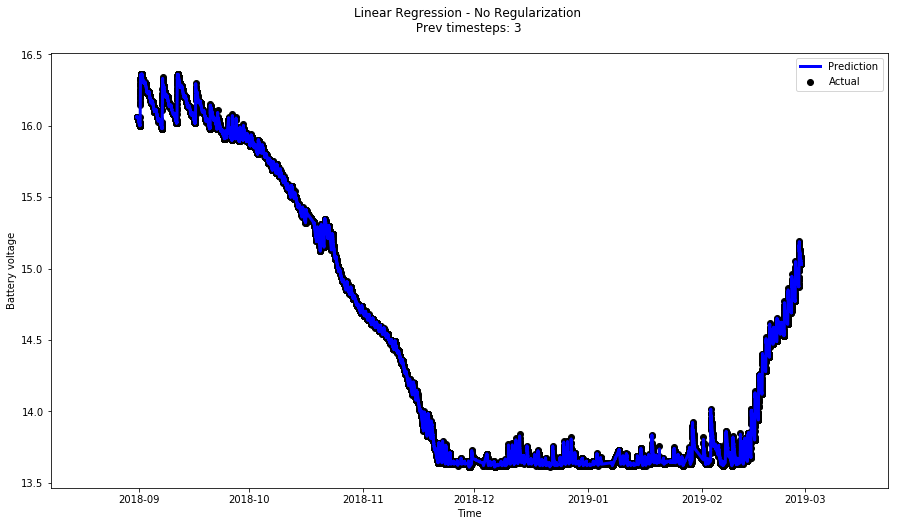

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 6.09725638e-03 -4.68708326e-04 -3.26789606e-03  6.62068339e-04
  -1.51950725e-04 -5.69123547e-04 -1.17012443e-04  8.17229795e-01
   1.69757069e-01  1.29202079e-02]]
Mean squared error: 0.00044
Variance score: 0.99631


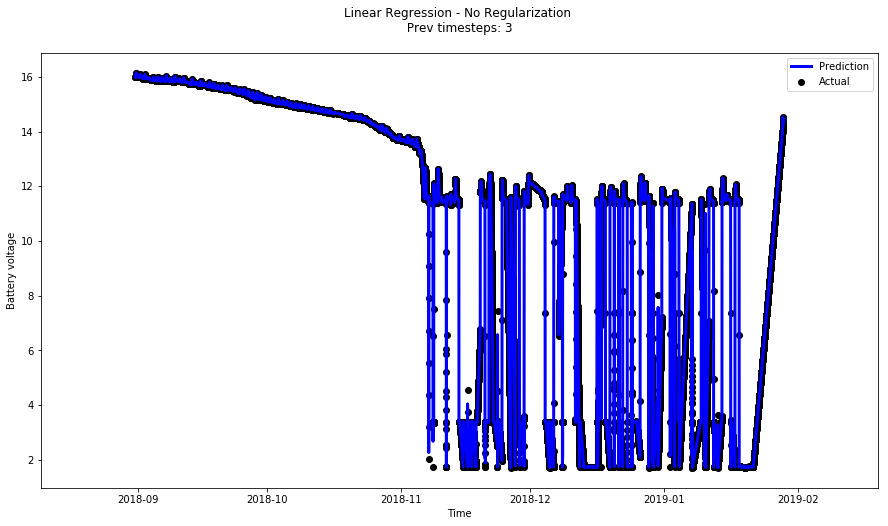

In [31]:
# Run experiment for battery pack nr 2
prev_timesteps = [0, 1, 3]
for ts in prev_timesteps:
    batt_nr = 2
    training_ratio = 0.7
    tr_regr, mse, r2 = linear_regression_experiment(batt_nr, ts, training_ratio, True, None)
    #print(tr_regr)
    batt_nr = 3
    training_ratio = 0
    linear_regression_experiment(batt_nr, ts, training_ratio, False, tr_regr)
    batt_nr = 1
    training_ratio = 0
    linear_regression_experiment(batt_nr, ts, training_ratio, False, tr_regr)

# Polynomial Regression

## Import library

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [175]:
def plot_pred_actual_poly(X_test, y_test, y_pred, prev_timesteps, batt_nr, n_degree, score):
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(y_test.index, y_test, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.legend()
    plt.title('Polynomial Regression (n = {}) - No Regularization \n Prev timesteps: {} \n Score: {}'.format(n_degree, prev_timesteps, score))
    plt.savefig(r'C:\Users\JeffG\Desktop\Case 1 - data\Results\Polynomial Regression' + '/ts_{}_batt_{}_n_{}'.format(prev_timesteps, batt_nr, n_degree))
    plt.show()
    return fig

## Using built-in functions

In [201]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)

a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps = 3
n_degree = 3

# Preprocess data
X, y = add_features(a, b, prev_timesteps)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=n_degree)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

Training score: 0.9999204975127519
Test score: 0.9998854786759487


In [202]:
print("Coefficients: ")
coeff = pd.DataFrame(pipeline.named_steps['model'].coef_)
print(coeff)
coeff.to_csv(r'C:\Users\JeffG\Desktop\Case 1 - data\Results\Polynomial Regression' + "/coeff.csv")

Coefficients: 
            0         1         2         3        4         5         6    \
0  6.471348e-09  0.002564  0.002692  0.003618  0.00079 -0.000212  0.048549   

        7         8         9    ...       276       277       278        279  \
0 -0.000291  0.495626  0.087264  ...  0.721499  5.806824 -6.655913 -13.399693   

         280       281       282        283       284       285  
0  13.264603 -0.390419  9.046122 -12.542552  5.704416 -1.555132  

[1 rows x 286 columns]


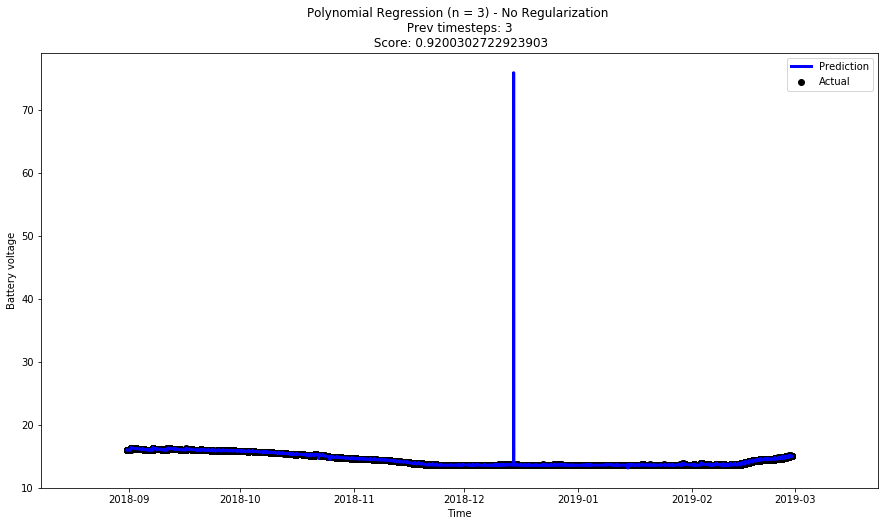

Test score: 0.9200302722923903


In [203]:
# Choose battery data
batt_nr = 3
battery_voltage = load_battery_voltage(batt_nr)
b = battery_voltage.copy()

# Preprocess data
X_test, y_test = add_features(a, b, prev_timesteps)

# Predict values based on trained set
y_pred = pipeline.predict(X_test)

# Plot the results
score = pipeline.score(X_test, y_test)
fig = plot_pred_actual_poly(X_test, y_test, y_pred, prev_timesteps, batt_nr, n_degree, score)
print('Test score: {}'.format(score))

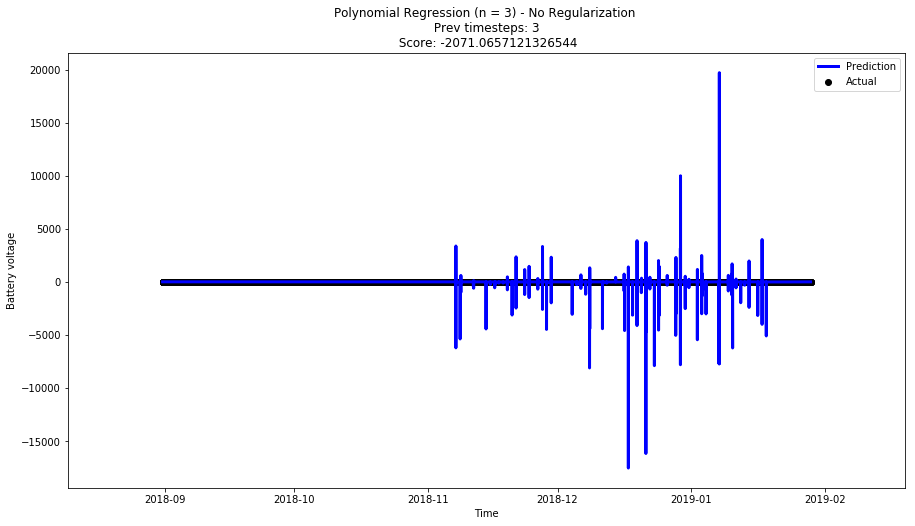

Test score: -2071.0657121326544


In [204]:
# Choose battery data
batt_nr = 1
battery_voltage = load_battery_voltage(batt_nr)
b = battery_voltage.copy()

# Preprocess data
X_test, y_test = add_features(a, b, prev_timesteps)

# Predict values based on trained set
y_pred = pipeline.predict(X_test)

# Plot the results
score = pipeline.score(X_test.iloc[0:len(y_test)], y_test)
fig = plot_pred_actual_poly(X_test, y_test, y_pred, prev_timesteps, batt_nr, n_degree, score)
print('Test score: {}'.format(score))

# Ridge Regression

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [240]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)

a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 3
prev_timesteps_bat = 0

# Extend the weather data with more timestamps
X_ext = series_to_supervised(a, a.index, a.columns, n_in=prev_timesteps_weather, n_out=1, dropnan=True)
X, y = add_features(X_ext, b, prev_timesteps_bat, prev_timesteps_weather)
print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# steps = [
#     ('scalar', StandardScaler()),
#     ('poly', PolynomialFeatures()),
#     ('model', Ridge())
# ]
# ridge_pipe = Pipeline(steps)
ridge_pipe = make_pipeline(
                StandardScaler(),
                PolynomialFeatures(),
                Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(ridge_pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
# print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test)))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

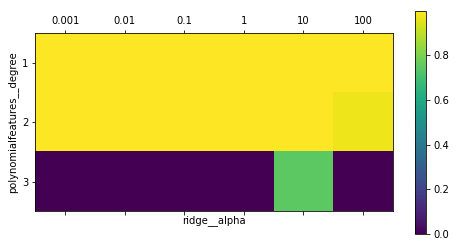

In [241]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1),
           vmin=0,cmap='viridis')
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [242]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'polynomialfeatures__degree': 1, 'ridge__alpha': 0.001}
Test-set score: 1.00


In [20]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 3
prev_timesteps_bat = 0

# Extend the weather data with more timestamps
X_ext = series_to_supervised(a, a.index, a.columns, n_in=prev_timesteps_weather, n_out=1, dropnan=True)
X, y = add_features(X_ext, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [24]:
X_train.head()

,environment.light(t-3),environment.temperature(t-3),weather.uv(t-3),environment.relativehumidity(t-3),weather.pressure(t-3),weather.rainrate(t-3),weather.windspeed(t-3),environment.light(t-2),environment.temperature(t-2),weather.uv(t-2),...,weather.pressure(t-1),weather.rainrate(t-1),weather.windspeed(t-1),environment.light(t),environment.temperature(t),weather.uv(t),environment.relativehumidity(t),weather.pressure(t),weather.rainrate(t),weather.windspeed(t)
time,,,,,,,,,,,,,,,,,,,,,
2018-12-18 01:35:00,0.0,7.100909,0.0,90.000000,1023.883068,0.0,5.407391,0.0,7.114186,0.0,...,1023.850000,0.0,4.504382,0.0,7.170000,0.0,90.523256,1023.741860,0.0,4.287093
2018-12-30 07:50:00,0.0,6.610000,0.0,90.000000,1035.019747,0.0,3.138481,0.0,6.634615,0.0,...,1035.079568,0.0,2.802593,0.0,6.670000,0.0,90.000000,1035.012778,0.0,4.154198
2018-12-26 07:20:00,0.0,0.615185,0.0,89.000000,1033.893333,0.0,2.742963,0.0,0.645926,0.0,...,1033.894753,0.0,1.520556,0.0,0.638889,0.0,89.000000,1033.944753,0.0,1.977716
2018-10-06 01:05:00,0.0,14.033617,0.0,78.900709,1011.993121,0.0,0.205532,0.0,13.976954,0.0,...,1011.858630,0.0,0.396986,0.0,13.867125,0.0,79.000000,1011.789750,0.0,0.110687
2018-10-01 04:20:00,0.0,10.606543,0.0,84.000000,1017.897407,0.0,0.457160,0.0,10.560000,0.0,...,1018.035625,0.0,1.911875,0.0,10.500000,0.0,82.234568,1018.023457,0.0,0.834815


In [23]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'ridge__alpha': 0.001}

Best cross-validation score: 0.46
Test-set score without poly features: 0.47
